# Problem Demonstration

In [1]:
import random
import torch
import numpy as np
from tqdm.auto import trange
from tqdm import tqdm

from scipy.optimize import minimize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.test_functions import Hartmann

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from matplotlib import pyplot as plt
plt.style.use('ggplot')

/Users/andrewf/miniconda3/envs/botorch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Some Helper Function

In [2]:
def set_seeds(seed=42):
    """set all library random seeds"""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sample(num_points, dims, seed=42):
    """generate random points in the domain"""
    set_seeds(seed)
    return torch.rand(num_points, dims, dtype=torch.double)

seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

In [15]:
seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)
n_init = 3
n_campaigns = 3
budget = 30-n_init # total num of experiments to do

data = np.zeros((n_campaigns, n_init+budget))

# generate starting data values
HART = Hartmann(dim=6, bounds=[(0,1)]*6 ,negate=True) # objective function - call with X, returns y values (like an experiment)
X_ = random_sample(n_init, 6) #  6 is num of dims 
y_ = torch.tensor([HART(x) for x in X_])[:,None]

for i in (pbar0 := trange(n_campaigns, leave=True, colour="red")): # this makes the text description appear when running the for loop (progress bar)
    set_seeds(seeds[i]) # set the random seed for the campaign
    X = X_.clone() # clone of starting values because they'll be modified
    y = y_.clone()


    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = SingleTaskGP(
            train_X = X,
            train_Y = y,
            input_transform=Normalize(d=X.shape[-1]), # normalize X values [0,1]
            outcome_transform=Standardize(m=y.shape[-1]) # standardize y values [mean of 0, std of 1]
        )

        # fit the model by maximizing the log marginal likelihood
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_model(mll)

        bounds = torch.tensor([[0.0]*X.shape[-1], [1.0]*X.shape[-1]])

        X_new, acq_value = optimize_acqf( # acq value is whatever came out of acqf (y value of acqf)
            acq_function= UpperConfidenceBound(gp, beta=2),  # beta= 2 std from mean
            bounds=bounds, # where to search for X values
            q=1, # how many new points to generate # one new experiment to do
            num_restarts = 20, # how many times to restart the optimizer
            raw_samples = 200 # how many initial points to sample acqf space from
        )

        X = torch.cat([X, X_new])
        y = torch.cat([y, HART(X=X_new)[:,None]]) # new exp observation is HART(X_new)

        pbar0.set_description(f"Processing Trial {j+1} of Campaign {i+1}")
        pbar1.set_description(f"Campaign {i+1} | Best Value {round(torch.max(y).item(),3)}")


    data[i,:] = y.flatten()
    # print(X)
    # print(y)
    # print(bounds)

  0%|          | 0/25 [00:00<?, ?it/s]

Campaign 1 | Best Value 3.274: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]t/s]
Campaign 2 | Best Value 3.277: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s], 21.59s/it]
Campaign 3 | Best Value 3.286: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s], 22.91s/it]
Campaign 4 | Best Value 3.229: 100%|██████████| 27/27 [00:23<00:00,  1.16it/s], 22.80s/it]
Campaign 5 | Best Value 3.29: 100%|██████████| 27/27 [00:21<00:00,  1.25it/s]2, 22.96s/it]
Campaign 6 | Best Value 3.279: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s], 22.47s/it]
Campaign 7 | Best Value 3.291: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s], 23.93s/it]
Campaign 8 | Best Value 3.295: 100%|██████████| 27/27 [00:24<00:00,  1.11it/s], 24.56s/it]
Campaign 9 | Best Value 3.296: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it], 24.48s/it]
Campaign 10 | Best Value 3.274: 100%|██████████| 27/27 [00:23<00:00,  1.13it/s], 25.64s/it]
Campaign 11 | Best Value 3.275: 100%|██████████| 27/27 [00:23<00:00,  1.17it/s]6, 25.11s/it]
Camp

In [31]:
# NEW AREA TO TEST OUT PARAMETER TESTING + STORING

# An idea for the hackathon: set n_campaigns=50 and then vary the num restarts and raw samples parameter on the optimize acqf function 
# and report some metrics on optimization performance.
# Things like mean final optimized value, min standard deviation at any given iteration, 
# max standard deviation at any iteration, and average standard deviation across all iterations. 
# We could then generate some heatmaps to see how they compare and where things fall apart. 
# You can probably just to a grid search to start.
from sklearn import model_selection

seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)
n_init = 3
n_campaigns = 10
budget = 15-n_init # total num of experiments to do

from sklearn.model_selection import ParameterGrid
param_grid = {'num_restart_': np.arange(start=10, stop=100, step=10), 'raw_samples_': np.arange(start=25, stop=300, step=25)}
# list(ParameterGrid(param_grid)) 
param_list = list(ParameterGrid(param_grid))
# param_list[0]['num_restart_']
param_count = 0
# int(param_list[0]['num_restart_'])
# len(param_list)


data = np.zeros((n_campaigns, n_init+budget))

# generate starting data values
HART = Hartmann(dim=6, bounds=[(0,1)]*6 ,negate=True) # objective function - call with X, returns y values (like an experiment)
X_ = random_sample(n_init, 6) #  6 is num of dims 
y_ = torch.tensor([HART(x) for x in X_])[:,None]

for i in (pbar0 := trange(n_campaigns, leave=True, colour="red")): # this makes the text description appear when running the for loop (progress bar)
    set_seeds(seeds[i]) # set the random seed for the campaign
    X = X_.clone() # clone of starting values because they'll be modified
    y = y_.clone()


    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = SingleTaskGP(
            train_X = X,
            train_Y = y,
            input_transform=Normalize(d=X.shape[-1]), # normalize X values [0,1]
            outcome_transform=Standardize(m=y.shape[-1]) # standardize y values [mean of 0, std of 1]
        )

        # fit the model by maximizing the log marginal likelihood
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = fit_gpytorch_model(mll)

        bounds = torch.tensor([[0.0]*X.shape[-1], [1.0]*X.shape[-1]])
        
        X_new, acq_value = optimize_acqf( # acq value is whatever came out of acqf (y value of acqf)
            acq_function= UpperConfidenceBound(gp, beta=2),  # beta= 2 std from mean
            bounds=bounds, # where to search for X values
            q=1, # how many new points to generate # one new experiment to do
            num_restarts = int(param_list[param_count]['num_restart_']), # how many times to restart the optimizer
            raw_samples = int(param_list[param_count]['raw_samples_']) # how many initial points to sample acqf space from
        )

        X = torch.cat([X, X_new])
        y = torch.cat([y, HART(X=X_new)[:,None]]) # new exp observation is HART(X_new)

        pbar0.set_description(f"Processing Trial {j+1} of Campaign {i+1}")
        pbar1.set_description(f"Campaign {i+1} | Best Value {round(torch.max(y).item(),3)}")

        # print(f"num_restarts= {param_list[param_count]['num_restart_']}")
        # print(f"raw_samples= {param_list[param_count]['raw_samples_']}")
    print(f"prev campaign num_restarts = {param_list[param_count]['num_restart_']}")
    print(f"prev campaign raw_samples = {param_list[param_count]['raw_samples_']}") 
        
    param_count += 1    
    # print(f"next campaign num_restarts= {param_list[param_count]['num_restart_']}")
    # print(f"next campaign raw_samples= {param_list[param_count]['raw_samples_']}")

    data[i,:] = y.flatten()
    


54

In [38]:
import pandas as pd

data_df = pd.DataFrame(data)
data_df.index = ['Campaign_'+str(i) for i in range(1, n_campaigns+1)]
data_df.columns = ['Trial_'+str(i) for i in range(1, 16)]

data_df['Num_Restarts'] = [param_list[i]['num_restart_'] for i in range(1, )]
data_df

,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10,Trial 11,Trial 12,Trial 13,Trial 14,Trial 15
Campaign 1,0.487247,0.018563,0.026071,0.157273,0.930331,1.197147,1.190321,0.869946,1.527112,1.557917,1.487938,1.893681,1.458140,2.039655,1.903091
Campaign 2,0.487247,0.018563,0.026071,0.233209,0.709990,0.802376,1.006517,1.107457,1.304284,1.272337,1.121827,1.346708,1.311281,1.936548,2.425146
Campaign 3,0.487247,0.018563,0.026071,0.268591,0.652309,0.677918,0.644614,0.860271,1.170602,1.131201,1.630803,1.624406,2.078939,2.171163,2.163026
Campaign 4,0.487247,0.018563,0.026071,0.193920,0.769326,0.721689,0.924862,1.060573,0.683679,1.379941,1.277975,1.450770,1.700423,1.354686,2.012689
Campaign 5,0.487247,0.018563,0.026071,0.188958,0.806410,0.934112,0.944411,1.074814,0.791705,1.252314,1.072780,1.636690,1.702086,1.933154,1.700584
Campaign 6,0.487247,0.018563,0.026071,0.155087,0.898081,1.060869,1.210111,1.203723,1.744017,1.629710,2.018915,1.890693,2.360937,2.436698,2.132418
Campaign 7,0.487247,0.018563,0.026071,0.165899,0.896397,1.112989,0.821045,1.416365,1.138407,1.653968,1.844796,1.596985,2.080094,1.911846,1.581716
Campaign 8,0.487247,0.018563,0.026071,0.163005,0.947744,1.252479,1.221154,1.243909,0.769020,1.633523,1.710636,1.264802,1.978230,1.835697,2.193171
Campaign 9,0.487247,0.018563,0.026071,0.136846,1.006000,1.391787,0.857529,1.805599,1.508401,2.064239,2.255574,2.120619,2.170582,2.319251,2.683530
Campaign 10,0.487247,0.018563,0.026071,0.157747,0.903266,1.091523,1.209302,1.649234,1.677428,1.530962,2.025407,2.068769,1.680576,2.315521,2.433041


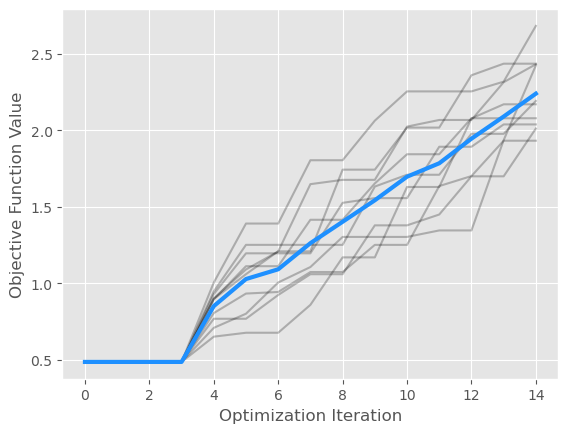

In [28]:
# mean final optimized value, 
# min standard deviation at any given iteration, 
# max standard deviation at any iteration, 
# average standard deviation across all iterations.

best_to_trial = np.maximum.accumulate(data, axis=1)
best_to_trial_mean = np.mean(best_to_trial, axis=0)
plt.plot(best_to_trial.T, color='black', alpha=0.25, label='trials')
plt.plot(best_to_trial_mean, lw=3, color='dodgerblue', label='mean')
plt.xlabel('Optimization Iteration')
plt.ylabel('Objective Function Value')
plt.show()



## An Example Random Restarts Optimizer

In [18]:
# define a UCB function for the scipy optimizer
def UCB(X, gp, beta=2):
    X = torch.tensor(X)
    mean = gp.posterior(X).mean
    std = gp.posterior(X).stddev
    UCB_val = mean + beta*std
    return -UCB_val.detach().numpy().item()

# build and train a simple model
HART = Hartmann(dim=6, bounds=[(0,1)]*6 ,negate=True)
X_ = random_sample(3, 6)
y_ = torch.tensor([HART(x) for x in X_])[:,None]

gp = SingleTaskGP(
    train_X = X_,
    train_Y = y_,
    input_transform=Normalize(d=X_.shape[-1]), # normalize X values
    outcome_transform=Standardize(m=y_.shape[-1]) # standardize y values
)

# iterate through the seeds and optimize the UCB function
vals = []
xs = []
for i in trange(30):
    set_seeds(seeds[i])
    res = minimize(
        UCB,
        method='L-BFGS-B',
        x0=random_sample(1, 6, seeds[i]).numpy().flatten(),
        args=(gp, 2),
        bounds=[(0,1)]*6,
        options={'maxiter': 1000, 'maxfun': 1000, 'ftol': 1e-20, 'gtol':1e-20, 'maxls':100}
    )
    vals.append(abs(res.fun))
    xs.append(res.x)


print("scipy_opt", gp.posterior(torch.tensor(res.x)).mean)
print("true_opt", HART(torch.tensor(res.x)))

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:18<00:00,  1.66it/s]

scipy_opt tensor([[0.2277]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
true_opt tensor(0.0478, dtype=torch.float64)


In [19]:
import pandas
xs = pandas.DataFrame(xs)
xs

,0,1,2,3,4,5
0,0.0,0.0,0.114187,0.0,0.760522,0.501352
1,0.0,0.0,0.114187,0.0,0.760522,0.501352
2,0.0,0.0,0.114187,0.0,0.760522,0.501352
3,0.0,0.0,0.114187,0.0,0.760522,0.501352
4,0.0,0.0,0.114187,0.0,0.760522,0.501352
5,0.0,0.0,0.114187,0.0,0.760522,0.501352
6,0.0,0.0,0.114187,0.0,0.760522,0.501352
7,0.0,0.0,0.114187,0.0,0.760522,0.501352
8,0.0,0.0,0.114187,0.0,0.760522,0.501352
9,0.0,0.0,0.114187,0.0,0.760522,0.501352
